### Measurement of Community Engagement

Given two communities C1 and C2, simply count the interactions that they had in a certain time frame.

This is done by looking at retweets between communities. So you count the amount of times C2 retweeted C1 in that time slice (C1toC2count) and viceverse (C1toC2count).

In [1]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
# For heatmap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pickle
from itertools import combinations

import pprint
import json
import glob
from random import random, randrange
import logging
from collections import defaultdict
import sys

import subprocess
import shlex
from scipy.stats import pearsonr

from datetime import datetime, timedelta
from dateutil.parser import parse
import datetime
from collections import Counter
from scipy.signal import savgol_filter
import itertools
import time
import csv
import pandas as pd

from tqdm import trange, tqdm

In [2]:
start_time = time.time()

## Load Data

## Start Processing

In [3]:
clusters = [13,48,6,49,104]
labels = ["Democrats","Republicans","Unorthodox","Public Health","Antivaxxers"]

In [4]:
pairs = list(itertools.combinations_with_replacement(clusters, 2))

In [5]:
recompute = False

In [6]:
if recompute:
    # Using the regular dictionary
    f = open('pruned_retweet_dict','rb')
    retweet_dict = pickle.load(f)
    f.close()
    elapsed_time = time.time() - start_time
    print("Elapsed time: " + str(elapsed_time))

In [7]:
if recompute:
    PT = nx.read_gexf('PT-pruned.gexf')

In [8]:
if recompute:
# Count retweets before and after the declaration of pandemic
    cutoff = datetime.datetime.strptime('11/03/20',"%d/%m/%y")
    before = 0
    after = 0
    latest_retweet = cutoff
    earliest_retweet = cutoff
    for tweet in tqdm(retweet_dict):
        for a,d in retweet_dict[tweet]['rt_list']:
            rt_date = datetime.datetime.strptime(d,'%y-%m-%d-%H:%M:%S')
            if (rt_date < cutoff):
                before += 1
            elif (cutoff < rt_date):
                after += 1
            if (latest_retweet < rt_date):
                latest_retweet = rt_date
            if (earliest_retweet > rt_date):
                earliest_retweet = rt_date

    print("Retweets before:",before)
    print("Retweets after:",after)
    print("The latest retweet on record is:", latest_retweet)
    print("The earliest retweet on record is:", earliest_retweet)
    elapsed_time = time.time() - start_time
    print("Elapsed time: " + str(elapsed_time))

In [9]:
if recompute:
    # Count tweets before and after the declaration of pandemic
    cutoff = datetime.datetime.strptime('11/03/20',"%d/%m/%y")
    before = 0
    after = 0
    latest_tweet = cutoff
    earliest_tweet = cutoff
    for tweet in retweet_dict:
        t_date = datetime.datetime.strptime(retweet_dict[tweet]['date'],'%y-%m-%d-%H:%M:%S')
        if (t_date < cutoff):
            before += 1
        elif (cutoff < t_date):
            after += 1
        if (latest_tweet < t_date):
            latest_tweet = t_date
        if (earliest_tweet > t_date):
            earliest_tweet = t_date

    print("Tweets before:",before)
    print("Tweets after:",after)
    print("The latest tweet on record is:", latest_tweet)
    print("The earliest tweet on record is:", earliest_tweet)
    elapsed_time = time.time() - start_time
    print("Elapsed time: " + str(elapsed_time))

##################################

### Compute the data

In [10]:
clusters = [13,48,6,49,104]
labels = ["Democrats","Republicans","Unorthodox","Public Health","Antivaxxers"]

In [11]:
results = pd.DataFrame(columns =['Retweeted Community Id','Retweeted Label','Retweeting Community Id','Retweeting Label',\
                                 'All Interaction', 'Before Interaction','After Interaction','Rate_Increase'])

In [12]:
def count_interactions(com1,com2):
    
    label1 = labels[clusters.index(com1)]
    label2 = labels[clusters.index(com2)]
    
    cut_date = datetime.datetime.strptime('11/03/20',"%d/%m/%y")

    # Nodes we care about
    authors1 = set()
    authors2 = set()
    for node in tqdm(PT.nodes):
        if PT.nodes[node]["louvain"] == com1:
            authors1.add(node)   
        if PT.nodes[node]["louvain"] == com2:
            authors2.add(node)
            
    all_int = int(0)
    before_int = int(0)    
    after_int = int(0)     
    # Now we loop over the dictionary
    for tweet in tqdm(retweet_dict):
        author = retweet_dict[tweet]['author']
        if author in authors1:
            for a,d in retweet_dict[tweet]['rt_list']:
                if (a in authors2) and (a != author):                  
                    rt_date = datetime.datetime.strptime(d,'%y-%m-%d-%H:%M:%S')
                    if (rt_date <= cut_date):
                        all_int += 1
                        before_int += 1
                    elif (cut_date < rt_date):
                        all_int += 1
                        after_int += 1
    rate_increase = after_int/before_int
    return np.array([com1,label1,com2,label2,all_int,before_int,after_int,rate_increase])

In [13]:
if recompute:
    count_interactions(48,104)

In [14]:
if recompute:
    results = pd.DataFrame(columns =['Retweeted_Community_Id','Retweeted_Label','Retweeting_Community_Id','Retweeting_Label',\
                                     'All_Interaction', 'Before_Interaction','After_Interaction','Rate_Increase'])

    pairs = list(itertools.product(clusters, repeat=2))
    for pair in pairs:
        data = count_interactions(pair[0],pair[1])
        results.loc[len(results)] = data
    results.to_csv("community_engagement.csv", index=False)

### Load computed data

In [15]:
clusters = [13,48,6,49,104]
labels = ["Democrats","Republicans","Unorthodox","Public Health","Antivaxxers"]

In [16]:
data = pd.read_csv('community_engagement.csv')

In [17]:
data.rename(columns={"Retweeted Community Id": "Retweeted_Community_Id", "Retweeted_Label": "Retweeted_Label",\
                    'Retweeting Community Id': 'Retweeting_Community_Id', 'Retweeting Label': 'Retweeting_Label',\
                    'All Interaction': 'All_Interaction', 'Before Interaction': 'Before_Interaction',\
                    'After Interaction': 'After_Interaction'})

,Retweeted_Community_Id,Retweeted_Label,Retweeting_Community_Id,Retweeting_Label,All_Interaction,Before_Interaction,After_Interaction,Rate_Increase
0,13,Democrats,13,Democrats,826825,187173,639652,3.417437
1,13,Democrats,48,Republicans,22178,5401,16777,3.106277
2,13,Democrats,6,Unorthodox,32809,6443,26366,4.092193
3,13,Democrats,49,Public Health,51264,10914,40350,3.697086
4,13,Democrats,104,Antivaxxers,9257,2111,7146,3.385126
5,48,Republicans,13,Democrats,10982,1989,8993,4.521368
6,48,Republicans,48,Republicans,1446344,147717,1298627,8.791317
7,48,Republicans,6,Unorthodox,8874,874,8000,9.153318
8,48,Republicans,49,Public Health,3456,528,2928,5.545455
9,48,Republicans,104,Antivaxxers,158507,14981,143526,9.580535


In [18]:
# 4: All interaction, 5: before, 6:after
# Row is retweeting
# column is retweeted
def get_interactions(k):
    df = pd.DataFrame(columns = labels, index = labels)
    for j in range(len(labels)): #j is retweeted, i is retweeting
        for i in range(len(labels)):
            eng = data[data['Retweeted_Label']==labels[j]].iloc[i][k] 
            df[labels[j]][i]=eng
    return df

In [19]:
df = get_interactions(4)

In [20]:
normalized_df=(df-df.mean())/df.std()
normalized_df

,Democrats,Republicans,Unorthodox,Public Health,Antivaxxers
Democrats,1.78719,-0.49953,-0.281854,-0.206723,-0.555599
Republicans,-0.465554,1.77921,-0.517998,-0.540925,-0.104861
Unorthodox,-0.43579,-0.502876,1.78076,-0.49939,-0.541905
Public Health,-0.384122,-0.511478,-0.49462,1.77194,-0.5529
Antivaxxers,-0.501728,-0.265324,-0.486289,-0.524897,1.75526


In [21]:
# Eliminating the diagonal for visualization
mean = df.mean()
sd = df.std()
no_diag = df.copy()
np.fill_diagonal(no_diag.values, mean)
# Normalize as before
normalized_no_diag=(no_diag-df.mean())/df.std()

mean

In [22]:
# Now transform to the relevant data types for heatmaps
toplot=normalized_no_diag.to_numpy()
toplot = toplot.astype(float)

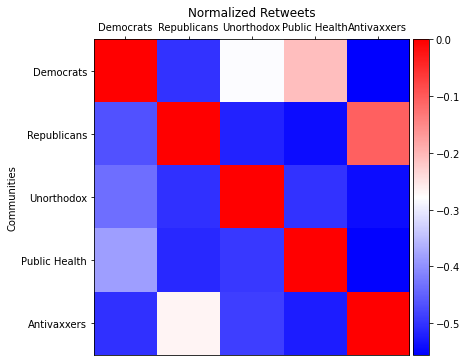

In [23]:
#basic plot, play with colormaps 
#here's the colormap reference: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#the default colormap is bad for a bunch of reasons 

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

#this actually makes the heatmap 
# List of cool cmaps at the end of:
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
im = ax.imshow(toplot,cmap='bwr')

#play with these if you want labels in different places, rotated, etc. 
ax.xaxis.set_label_position('top')  
ax.tick_params(top=True, bottom=False,
           labeltop=True, labelbottom=False)
ax.set_yticks(range(5))
ax.set_xticks(range(5))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

#basic labels 
ax.set_title("Normalized Retweets")
ax.set_ylabel("Communities")

#this bit of code splits the axis nicely and puts a colorbar
# if you're just playing around, you can just do plt.colorbar() and it will jam a big colorbar next to the last thing you did
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()



#### Plotting

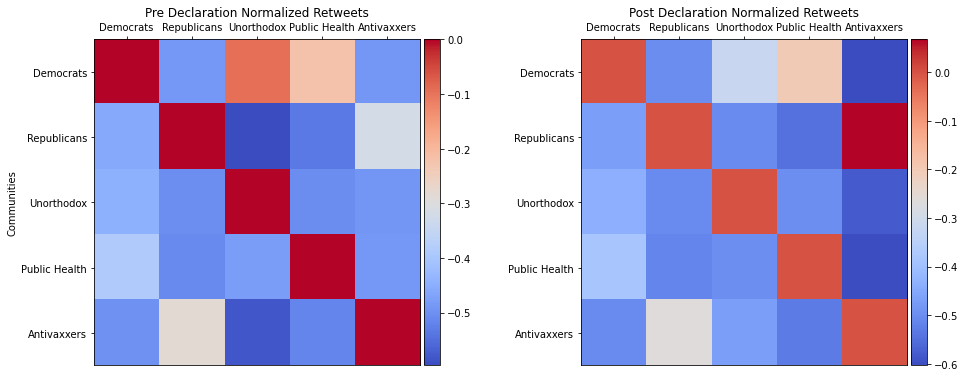

In [30]:
# Create data frame with relevant info
df = get_interactions(5)

# Eliminating the diagonal for visualization
mean = df.mean()
sd = df.std()
no_diag = df.copy()
np.fill_diagonal(no_diag.values, mean)
# MEAN NORMALIZE as before
normalized_no_diag=(no_diag-df.mean())/df.std()

# Now transform to the relevant data types for heatmaps
toplot=normalized_no_diag.to_numpy()
toplot = toplot.astype(float)


#basic plot, play with colormaps 
#here's the colormap reference: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#the default colormap is bad for a bunch of reasons 

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121) # For example, "111" means "1x1 grid, first subplot" and "234" means "2x3 grid, 4th subplot".

#this actually makes the heatmap 
# List of cool cmaps at the end of:
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
im = ax.imshow(toplot,cmap='coolwarm')

#play with these if you want labels in different places, rotated, etc. 
ax.xaxis.set_label_position('top')  
ax.tick_params(top=True, bottom=False,
           labeltop=True, labelbottom=False)
ax.set_yticks(range(5))
ax.set_xticks(range(5))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

#basic labels 
ax.set_title("Pre Declaration Normalized Retweets")
ax.set_ylabel("Communities")
# ax.set_xlabel("another group")

#this bit of code splits the axis nicely and puts a colorbar
# if you're just playing around, you can just do plt.colorbar() and it will jam a big colorbar next to the last thing you did
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# SECOND PLOT
# Create data frame with relevant info
df = get_interactions(6)
        
# Eliminating the diagonal for visualization
mean = df.mean()
sd = df.std()
no_diag = df.copy()
np.fill_diagonal(no_diag.values, mean)
# MEAN NORMALIZE as before
normalized_no_diag=(no_diag-df.mean())/df.std()

# Now transform to the relevant data types for heatmaps
toplot=normalized_no_diag.to_numpy()
toplot = toplot.astype(float)

ax = fig.add_subplot(122) # For example, "111" means "1x1 grid, first subplot" and "234" means "2x3 grid, 4th subplot".

#this actually makes the heatmap 
# List of cool cmaps at the end of:
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
im = ax.imshow(toplot,cmap='coolwarm')

#play with these if you want labels in different places, rotated, etc. 
ax.xaxis.set_label_position('top')  
ax.tick_params(top=True, bottom=False,
           labeltop=True, labelbottom=False)
ax.set_yticks(range(5))
ax.set_xticks(range(5))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

#basic labels 
ax.set_title("Post Declaration Normalized Retweets")
# ax.set_ylabel("Communities")
# ax.set_xlabel("another group")

#this bit of code splits the axis nicely and puts a colorbar
# if you're just playing around, you can just do plt.colorbar() and it will jam a big colorbar next to the last thing you did
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


plt.show()


##### Rate

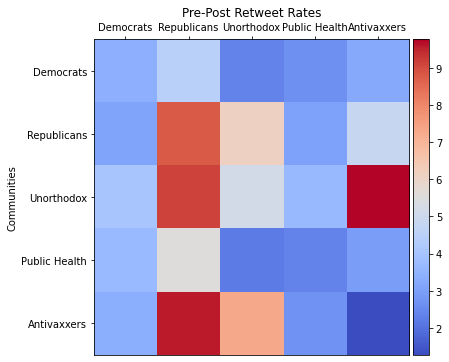

In [28]:
# Create data frame with relevant info

# columna es retweeting
# fila es retweeted
df = get_interactions(7)

# Eliminating the diagonal for visualization
mean = df.mean()
sd = df.std()
no_diag = df.copy()
#np.fill_diagonal(no_diag.values, mean)
# DO NOT MEAN NORMALIZE as before
normalized_no_diag=(no_diag-df.mean())/df.std()

# Now transform to the relevant data types for heatmaps
#toplot=normalized_no_diag.to_numpy()

toplot = df.to_numpy()
toplot = toplot.astype(float)

#basic plot, play with colormaps 
#here's the colormap reference: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
#the default colormap is bad for a bunch of reasons 

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

#this actually makes the heatmap 
# List of cool cmaps at the end of:
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
im = ax.imshow(toplot,cmap='coolwarm')

#play with these if you want labels in different places, rotated, etc. 
ax.xaxis.set_label_position('top')  
ax.tick_params(top=True, bottom=False,
           labeltop=True, labelbottom=False)
ax.set_yticks(range(5))
ax.set_xticks(range(5))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

#basic labels 
ax.set_title("Pre-Post Retweet Rates")
ax.set_ylabel("Communities")

#this bit of code splits the axis nicely and puts a colorbar
# if you're just playing around, you can just do plt.colorbar() and it will jam a big colorbar next to the last thing you did
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

